/tmp/ipython-input-4-2750989278.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, "2015-01-01", "2025-01-01")['Close']
[*********************100%***********************]  4 of 4 completed
/tmp/ipython-input-4-2750989278.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.1907026]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= alpha


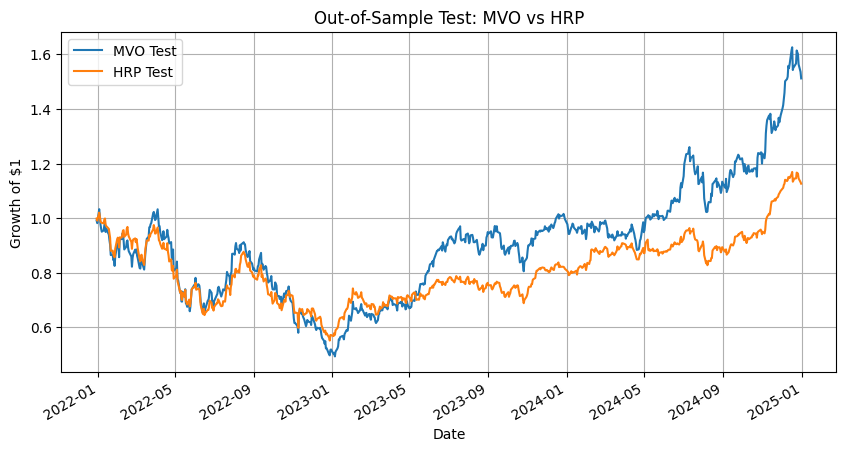

     Cumulative Return  CAGR  Volatility  Sharpe  Max Drawdown
MVO               0.51  0.15        0.36    0.42         -0.52
HRP               0.13  0.04        0.27    0.15         -0.46


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

tickers = ['AAPL', 'AMZN', 'DIS', 'TSLA']
data = yf.download(tickers, "2015-01-01", "2025-01-01")['Close']
returns = data.pct_change().dropna()

# Split 70/30
split = int(len(returns) * 0.7)
train, test = returns[:split], returns[split:]

def correl_to_dist(corr):
    return np.sqrt(0.5 * (1 - corr))

def get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index; j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1])
        sort_ix = sort_ix.sort_index()
    return sort_ix.tolist()

def get_hrp_weights(cov, corr):
    dist = correl_to_dist(corr)
    link = linkage(squareform(dist), 'single')
    sort_ix = get_quasi_diag(link)
    ordered_cols = corr.columns[sort_ix]
    weights = pd.Series(1, index=ordered_cols)
    clusters = [ordered_cols.tolist()]
    while clusters:
        clusters = [c[i:j] for c in clusters for i,j in ((0,len(c)//2),(len(c)//2,len(c))) if len(c)>1]
        for c in clusters:
            left, right = c[:len(c)//2], c[len(c)//2:]
            cov_slice = cov.loc[c, c]
            inv_diag = 1 / np.diag(cov_slice)
            alloc = pd.Series(inv_diag / inv_diag.sum(), index=cov_slice.columns) # Corrected line
            alpha = alloc[left].sum()
            weights[left] *= alpha
            weights[right] *= 1 - alpha
    return weights / weights.sum()

# MVO weights
mean_ret = train.mean()
cov_train = train.cov()
inv_cov = np.linalg.inv(cov_train)
w_mvo = pd.Series(inv_cov.dot(mean_ret), index=mean_ret.index)
w_mvo /= w_mvo.sum()

# HRP weights
corr_train = train.corr()
w_hrp = get_hrp_weights(cov_train, corr_train)

test_mvo = test.dot(w_mvo)
test_hrp = test.dot(w_hrp)

cum_mvo = (1 + test_mvo).cumprod()
cum_hrp = (1 + test_hrp).cumprod()

# Plot comparison
cum_mvo.plot(label='MVO Test', figsize=(10,5))
cum_hrp.plot(label='HRP Test')
plt.title("Out-of-Sample Test: MVO vs HRP")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

def metrics(returns):
    cr = (1 + returns).prod() - 1
    ar = (1 + cr) ** (252/len(returns)) - 1
    vol = returns.std() * np.sqrt(252)
    sharpe = ar / vol
    # Max Drawdown calculation needs cumulative returns
    cum_returns = (1 + returns).cumprod()
    mdd = (cum_returns / cum_returns.cummax() - 1).min()
    return cr, ar, vol, sharpe, mdd

mvo_metrics = metrics(test_mvo)
hrp_metrics = metrics(test_hrp)

df = pd.DataFrame([mvo_metrics, hrp_metrics],
                  index=['MVO','HRP'],
                  columns=['Cumulative Return','CAGR','Volatility','Sharpe','Max Drawdown'])
print(df.round(2))

In [9]:
import pandas as pd
import numpy as np

def performance_metrics(daily_returns, name):
    cumulative_return = (1 + daily_returns).prod() - 1
    annual_return = (1 + cumulative_return) ** (252 / len(daily_returns)) - 1
    annual_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    # Max Drawdown calculation needs cumulative returns
    cum_returns = (1 + daily_returns).cumprod()
    max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()


    return pd.Series({
        'Cumulative Return': cumulative_return,
        'Annual Return (CAGR)': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }, name=name)

# Assuming `mvo_returns` and `hrp_returns` are already defined as daily return series
mvo_metrics = performance_metrics(test_mvo, "MVO")
hrp_metrics = performance_metrics(test_hrp, "HRP")

# Combine into a DataFrame
comparison = pd.concat([mvo_metrics, hrp_metrics], axis=1)
print(comparison.to_string(float_format='{:.2f}'.format))

                       MVO   HRP
Cumulative Return     0.51  0.13
Annual Return (CAGR)  0.15  0.04
Annual Volatility     0.36  0.27
Sharpe Ratio          0.42  0.15
Max Drawdown         -0.52 -0.46
